In [1]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl

# Import extinction maps
from dustmaps.sfd import SFDQuery

filter = ['u', 'g', 'r', 'i', 'z']
color = ['ug', 'gr', 'ri', 'iz']
color_label = ['u - g', 'g - r', 'r - i', 'i - z']


Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-5.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


#### <span style='color:blue'> Load  the Montreal  White Dwarf Data Base and make it compatible with the Warwick Catalog</span>

In [2]:
# Load the (slightly filtered) Montreal White Dwarf Database
df_MontWD = pd.read_csv('MWDD-export.csv', low_memory=False)

# Get rid of some spaces that make it hard to read
# df_MontWD['su'].replace('', np.nan, inplace=True)
df_MontWD.replace('', np.nan, inplace=True)
df_MontWD.replace('      ', np.nan, inplace=True)

print('Original # of rows for Montreal WD Catalog: %d' %len(df_MontWD))
print('Original Columns for Montreal WD Catalog')
print(df_MontWD.columns)
df_MontWD.head()


Original # of rows for Montreal WD Catalog: 34505
Original Columns for Montreal WD Catalog
Index(['wdid', 'name', 'wdname', 'icrsra', 'icrsdec', 'spectype', 'teff',
       'logg', 'parallax', 'Dpc', 'G', 'DG', 'BP', 'RP'],
      dtype='object')


,wdid,name,wdname,icrsra,icrsdec,spectype,teff,logg,parallax,Dpc,G,DG,BP,RP
0,1FGL J1338.9+1153,Gaia DR2 3738720961894478464,NaN,13 38 59.06,11 53 16.73,DC,6300.0,10.00,-0.178937,NaN,18.526047,NaN,18.772249,17.900059
1,1RXS J000359.1+433600,Gaia EDR3 384841336150015360,WD 0001+433,00 03 58.84,43 36 01.64,DA,46850.0,9.05,7.869191,127.08,16.712538,0.004078,16.554335,17.038767
2,1RXS J023947.9+500349,Gaia EDR3 450931644363332352,WD 0236+498,02 39 48.39,50 03 48.27,DA,34150.0,8.67,9.446556,105.86,15.721684,0.003209,15.570930,16.022203
3,1RXS J041051.2+592522,Gaia EDR3 470502504662843648,WD 0406+592,04 10 51.65,59 25 01.54,DA,30640.0,7.94,10.521743,95.04,14.724578,0.001437,14.583176,14.989646
4,1RXS J055047.4-240853,Gaia EDR3 2915555883657897344,WD 0548-241,05 50 46.74,-24 08 50.44,DA,54380.0,8.02,3.461348,288.90,16.235077,0.002293,16.076183,16.559160


In [3]:
# Get rid of the "GaiaEDR3" or "GaiaDR2" titles (etc.?) to turn df_MontWD['name'] 
# into a df_MontWD['source_id_2'] that's compatible with the Warwick data.
# Convert all the Gaia Source ID's to strings for compatibility.

GaiaEDR3 = []
for i in range(len(df_MontWD)):
    if df_MontWD['name'][i].startswith('Gaia'):
        GaiaEDR3.append(int(df_MontWD['name'][i][9:]))
    else:
        GaiaEDR3.append('NaN')    

source_id_2 = []
for i in range(len(df_MontWD)):
    source_id_2.append(str(GaiaEDR3[i]))

df_MontWD['source_id_2'] = source_id_2
                       

In [4]:
# Limit the database to DA, DB and DC WD's
df_MontWD = df_MontWD[(df_MontWD['spectype'] == 'DA') | (df_MontWD['spectype'] == 'DB') | 
                     (df_MontWD['spectype'] == 'DC') ]
print('# of rows for Montreal Catalog DA, DB, DC WDs: %d' %len(df_MontWD))

# of rows for Montreal Catalog DA, DB, DC WDs: 31026


In [5]:
df_MontWD.columns

Index(['wdid', 'name', 'wdname', 'icrsra', 'icrsdec', 'spectype', 'teff',
       'logg', 'parallax', 'Dpc', 'G', 'DG', 'BP', 'RP', 'source_id_2'],
      dtype='object')

In [6]:
df_MontWD = df_MontWD.drop(columns=['wdid', 'name', 'wdname', 'icrsra', 'icrsdec', 'teff',
       'logg', 'parallax', 'Dpc', 'G', 'DG', 'BP', 'RP'], axis=1)

In [7]:
df_MontWD = df_MontWD.reset_index()
df_MontWD.columns


Index(['index', 'spectype', 'source_id_2'], dtype='object')

#### <span style='color:blue'> The Montreal WD Database for DA, DB and DC WD's only is ready to merge. Now load the Warwick Catalog.

In [8]:
df_WDcat = pd.read_csv('gaia-sdss_white_dwarf_catalogue_v2.1.csv')

print('Original # of rows for Warwick Catalog Database: %d' %len(df_WDcat))
print()
print('Original Columns for Warwick Candidate Database')
print(df_WDcat.columns)
print()


Original # of rows for Warwick Catalog Database: 37259

Original Columns for Warwick Candidate Database
Index(['white_dwarf_name', 'source_id_2', 'SDSS_name', 'SDSS_ra', 'SDSS_dec',
       'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag',
       'zmag', 'e_zmag', 'Plate', 'mjd', 'fiberID', 'S/N', 'spectral_class'],
      dtype='object')



In [9]:
df_WDcat = df_WDcat.rename(columns={'white_dwarf_name':'WDJname'}, errors='raise')
df_WDcat = df_WDcat.rename(columns={'spectral_class':'spectype'}, errors='raise')


In [10]:
df_WDcat = df_WDcat[(df_WDcat['spectype'] == 'DA') | (df_WDcat['spectype'] == 'DB') | 
                     (df_WDcat['spectype'] == 'DC') ]
print('# of rows for Warwick Catalog DA, DB, DC WDs: %d' %len(df_WDcat))

# of rows for Warwick Catalog DA, DB, DC WDs: 25405


In [11]:
df_WDcat = df_WDcat.drop(columns=['WDJname', 'SDSS_name', 'SDSS_ra', 'SDSS_dec', 
        'S/N', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 
        'e_imag', 'zmag', 'e_zmag', 'Plate', 'mjd', 'fiberID'], axis=1)

In [12]:
df_WDcat = df_WDcat.reset_index()
df_WDcat.columns

Index(['index', 'source_id_2', 'spectype'], dtype='object')

In [13]:
# Collect the Gaia ID's and spectral types for both WD databases into one list
# and open up a new DataFrame.
source_id_2 = []
spectype = []
for i in range(len(df_MontWD)):
    source_id_2.append(str(df_MontWD['source_id_2'][i]))
    spectype.append(df_MontWD['spectype'][i])

for i in range(len(df_WDcat)):
    source_id_2.append(str(df_WDcat['source_id_2'][i]))
    spectype.append(df_WDcat['spectype'][i])

# Make a new DataFrame with the combined WD catalogs and an ID column that matches
# the name of the Gaia catalog's column:    
df = pd.DataFrame()
df['GaiaEDR3'] = source_id_2
df['spectype'] = spectype

print('Number of rows combined is %d' %len(df['GaiaEDR3']))

df.drop_duplicates('GaiaEDR3')
print('Number of unique ID rows is %d' %len(df['GaiaEDR3']))


Number of rows combined is 56431
Number of unique ID rows is 56431


In [14]:
del df_MontWD, df_WDcat

#### <span style='color:blue'> Load the Gaia database (Bailer-Jones?) </span>

In [15]:
# An object to convert a votable file to a Pandas table
from astropy.io.votable import parse

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [16]:
# Download the Gaia data from VizieR as a votable file and make a Pandas table
df_Gaia = votable_to_pandas('vizier_votable.vot')

print('No. of Rows for Acquired Gaia Dataset: %6d' %len(df_Gaia))
print()
print('GAIA TABLE COLUMNS')
df_Gaia.columns


No. of Rows for Acquired Gaia Dataset: 322915

GAIA TABLE COLUMNS


Index(['WDJname', 'GaiaEDR3', 'RA_ICRS', 'DE_ICRS', 'Plx', 'Pwd', 'PM', 'pmRA',
       'pmDE', 'Gmag', 'BPmag', 'RPmag', 'TeffH', 'e_TeffH', 'loggH',
       'e_loggH', 'MassH', 'TeffHe', 'e_TeffHe', 'loggHe', 'e_loggHe',
       'MassHe', 'Teffmix', 'e_Teffmix', 'loggmix', 'e_loggmix', 'rgeo',
       'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'SDSS12', 'umag',
       'gmag', 'rmag', 'imag', 'zmag', '_RA.icrs', '_DE.icrs', 'recno'],
      dtype='object')

In [17]:
df_Gaia.head()

,WDJname,GaiaEDR3,RA_ICRS,DE_ICRS,Plx,Pwd,PM,pmRA,pmDE,Gmag,...,B_rpgeo,SDSS12,umag,gmag,rmag,imag,zmag,_RA.icrs,_DE.icrs,recno
0,WDJ053500.22-363751.68,4809697548510762752,83.750862,-36.631246,3.3630,0.917622,51.294,-8.717,-50.548,20.320801,...,351.731049,,NaN,NaN,NaN,NaN,NaN,83.750911,-36.631022,119168
1,WDJ053500.29-083633.49,3015468539632052608,83.751199,-8.609295,2.8238,0.984751,3.938,-3.619,1.551,19.988899,...,405.107391,,NaN,NaN,NaN,NaN,NaN,83.751216,-8.609302,119169
2,WDJ053500.39-413813.29,4806152723023126016,83.751729,-41.637052,4.7861,0.937591,17.304,16.212,-6.051,20.685101,...,275.614197,,NaN,NaN,NaN,NaN,NaN,83.751633,-41.637025,119170
3,WDJ053500.58+641835.35,287633925457383040,83.752421,64.309714,2.9600,0.999280,23.538,0.072,-23.538,18.966299,...,386.411713,,NaN,NaN,NaN,NaN,NaN,83.752420,64.309819,119172
4,WDJ053500.66+342657.23,3449585550235772672,83.752702,34.449209,8.1097,0.992275,9.851,-8.801,-4.427,19.027300,...,127.991325,,NaN,NaN,NaN,NaN,NaN,83.752750,34.449228,119173


In [18]:
df.columns

Index(['GaiaEDR3', 'spectype'], dtype='object')

In [19]:
# Convert all GAIA ID's to strings
GaiaEDR3 = []
for i in range(len(df_Gaia)):
    GaiaEDR3.append(str(df_Gaia['GaiaEDR3'][i]))

df_Gaia['GaiaEDR3'] = GaiaEDR3
df_Gaia = df_Gaia.reset_index()

In [20]:
df_merge = pd.merge(df_Gaia, df, on='GaiaEDR3')

In [21]:
# define a function to calculate galactic coordinates
def get_galactic_coord(row):
    c = SkyCoord(ra=row['RA_ICRS']*u.degree, dec=row['DE_ICRS']*u.degree, frame='icrs')
    row['l'] = c.galactic.l.degree
    row['b'] = c.galactic.b.degree
    return row



In [22]:
df_merge.columns

Index(['index', 'WDJname', 'GaiaEDR3', 'RA_ICRS', 'DE_ICRS', 'Plx', 'Pwd',
       'PM', 'pmRA', 'pmDE', 'Gmag', 'BPmag', 'RPmag', 'TeffH', 'e_TeffH',
       'loggH', 'e_loggH', 'MassH', 'TeffHe', 'e_TeffHe', 'loggHe', 'e_loggHe',
       'MassHe', 'Teffmix', 'e_Teffmix', 'loggmix', 'e_loggmix', 'rgeo',
       'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'SDSS12', 'umag',
       'gmag', 'rmag', 'imag', 'zmag', '_RA.icrs', '_DE.icrs', 'recno',
       'spectype'],
      dtype='object')

In [23]:
print(df_merge.spectype.unique())
print()
print('WD Type    #')
print(df_merge.spectype.value_counts())

['DA' 'DC' 'DB']

WD Type    #
DA    38969
DC     4699
DB     3249
Name: spectype, dtype: int64


In [24]:
len(df_merge)

46917

In [25]:
print(len(df_merge))
df_merge = df_merge.drop_duplicates('GaiaEDR3')
print(len(df_merge))

df_merge = df_merge[ ( df_merge['umag'] > 5.) & (df_merge['umag'] < 22.)
                 & (df_merge['gmag'] > 5.) & (df_merge['gmag'] < 22.)
                 & (df_merge['rmag'] > 15.) & (df_merge['rmag'] < 19.)
                 & (df_merge['imag'] > 5.) & (df_merge['imag'] < 22.)
                 & (df_merge['zmag'] > 5.) & (df_merge['zmag'] < 22.)]

print(len(df_merge))

# apply the galactic coordinate calculation to each row using the apply method
# and limit WD's to b > 15 degrees.
df_merge = df_merge.apply(get_galactic_coord, axis=1)
df_merge = df_merge[(np.abs(df_merge['b']) > 15.)]
print(len(df_merge))
df_merge = df_merge[df_merge['Pwd'] >= 0.9]
print(len(df_merge))
df_merge = df_merge.drop(columns=['WDJname', '_RA.icrs', '_DE.icrs'], axis=1)
df_merge = df_merge.dropna()
print(len(df_merge))
df_merge = df_merge.reset_index()

46917
24515
8721
8547
8526
7077


In [26]:
df_merge.columns

Index(['level_0', 'index', 'GaiaEDR3', 'RA_ICRS', 'DE_ICRS', 'Plx', 'Pwd',
       'PM', 'pmRA', 'pmDE', 'Gmag', 'BPmag', 'RPmag', 'TeffH', 'e_TeffH',
       'loggH', 'e_loggH', 'MassH', 'TeffHe', 'e_TeffHe', 'loggHe', 'e_loggHe',
       'MassHe', 'Teffmix', 'e_Teffmix', 'loggmix', 'e_loggmix', 'rgeo',
       'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'SDSS12', 'umag',
       'gmag', 'rmag', 'imag', 'zmag', 'recno', 'spectype', 'l', 'b'],
      dtype='object')

In [27]:
len(df_merge)

7077

In [28]:
df_DA = df_merge[df_merge['spectype'] == 'DA']
df_DB = df_merge[df_merge['spectype'] == 'DB']
df_DC = df_merge[df_merge['spectype'] == 'DC']

In [29]:
len(df_DA), len(df_DB), len(df_DC)

(5870, 702, 505)

(array([2.149e+03, 2.317e+03, 1.070e+03, 2.340e+02, 5.400e+01, 2.300e+01,
        1.400e+01, 5.000e+00, 1.000e+00, 3.000e+00]),
 array([  18.1360302 ,  155.87136518,  293.60670016,  431.34203514,
         569.07737012,  706.8127051 ,  844.54804008,  982.28337506,
        1120.01871004, 1257.75404502, 1395.48938   ]),
 <BarContainer object of 10 artists>)

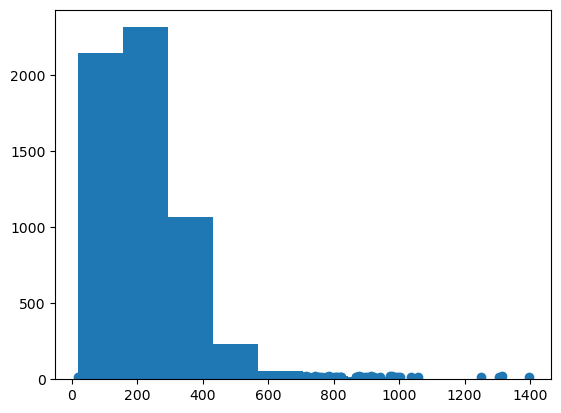

In [30]:
plt.scatter(df_DA['rpgeo'], df_DA['umag'])
plt.hist(df_DA['rpgeo'])

In [32]:
df_merge.to_csv('MontWarWDs.csv')